# 確率ロボティクス課題

## 参考
+ [詳解 確率ロボティクス](https://www.amazon.co.jp/%E8%A9%B3%E8%A7%A3-%E7%A2%BA%E7%8E%87%E3%83%AD%E3%83%9C%E3%83%86%E3%82%A3%E3%82%AF%E3%82%B9-Python%E3%81%AB%E3%82%88%E3%82%8B%E5%9F%BA%E7%A4%8E%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0%E3%81%AE%E5%AE%9F%E8%A3%85-KS%E7%90%86%E5%B7%A5%E5%AD%A6%E5%B0%82%E9%96%80%E6%9B%B8-%E4%B8%8A%E7%94%B0/dp/4065170060/ref=sr_1_1?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&dchild=1&keywords=%E8%A9%B3%E8%A7%A3+%E7%A2%BA%E7%8E%87%E3%83%AD%E3%83%9C%E3%83%86%E3%82%A3%E3%82%AF%E3%82%B9&qid=1610537879&sr=8-1)
+ [確率ロボティクス](https://www.amazon.co.jp/%E7%A2%BA%E7%8E%87%E3%83%AD%E3%83%9C%E3%83%86%E3%82%A3%E3%82%AF%E3%82%B9-%E3%83%97%E3%83%AC%E3%83%9F%E3%82%A2%E3%83%A0%E3%83%96%E3%83%83%E3%82%AF%E3%82%B9%E7%89%88-Sebastian-Thrun/dp/4839952981/ref=sr_1_2?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&dchild=1&keywords=%E8%A9%B3%E8%A7%A3+%E7%A2%BA%E7%8E%87%E3%83%AD%E3%83%9C%E3%83%86%E3%82%A3%E3%82%AF%E3%82%B9&qid=1610537879&sr=8-2)
+ [詳解 確率ロボティクスのサンプルコード](https://github.com/ryuichiueda/LNPR_BOOK_CODES)
+ [自己位置推定](https://github.com/KobayashiRui/ProbabilisticRobotics_Task)

## 問題設定
+ 授業で扱ったマルコフ決定過程の全方向移動バージョンを実装
+ ロボットはx,y方向に移動可能
+ 回転はしない
+ 自己位置推定は去年の先輩のコードを引用しています

コードの変数名やクラス名は基本的に参考の「詳解　確率ロボティクス」に準拠しています

In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm

import math
import numpy as np
from scipy.stats import expon, norm, multivariate_normal
from matplotlib.patches import Ellipse

import itertools 
import collections 
from copy import copy

## Worldの作成
goal puddle Landmark

In [2]:
class Goal:
    def __init__(self, x, y, radius=0.3, value=0.0):
        self.pos = np.array([x, y]).T
        self.radius = radius
        self.value = value   
        
    def inside(self, pose): #ゴールの範囲設定
        return self.radius > math.sqrt( (self.pos[0]-pose[0])**2 + (self.pos[1]-pose[1])**2 )
        
    def draw(self, ax, elems):
        x, y = self.pos
        c = ax.scatter(x + 0.16, y + 0.5, s=50, marker=">", label="landmarks", color="red")
        elems.append(c)
        elems += ax.plot([x, x], [y, y + 0.6], color="black")

In [3]:
class Puddle: #水たまり
    def __init__(self, lowerleft, upperright, depth):
        self.lowerleft = lowerleft
        self.upperright = upperright
        self.depth = depth
        
    def draw(self, ax, elems):
        w = self.upperright[0] - self.lowerleft[0]
        h = self.upperright[1] - self.lowerleft[1]
        r = patches.Rectangle(self.lowerleft, w, h, color="blue", alpha=self.depth)
        elems.append(ax.add_patch(r))
        
    def inside(self, pose): 
        return all([ self.lowerleft[i] < pose[i] < self.upperright[i]  for i in [0, 1] ])

In [4]:
class PuddleWorld():
    def __init__(self, time_span, time_interval, debug=False):
        self.objects = []
        self.debug = debug
        self.time_span = time_span
        self.time_interval = time_interval
        
        self.puddles = []
        self.robots = []
        self.goals = []
        
    def draw(self): 
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')             
        ax.set_xlim(-5,5)                  
        ax.set_ylim(-5,5) 
        ax.set_xlabel("X",fontsize=10)                 
        ax.set_ylabel("Y",fontsize=10)                 
        
        elems = []
        
        if self.debug:        
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            plt.show()
    
    def append(self,obj):
        self.objects.append(obj)
        if isinstance(obj, Puddle): self.puddles.append(obj)
        if isinstance(obj, Robot): self.robots.append(obj)
        if isinstance(obj, Goal): self.goals.append(obj)
        
    def puddle_depth(self, pose):
        return sum([p.depth * p.inside(pose) for p in self.puddles])
                    
    def one_step(self, i, elems, ax):
        while elems:
            elems.pop().remove()
        time_str = "t=%.2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"):
                obj.one_step(self.time_interval)
        for r in self.robots:
            r.agent.puddle_depth = self.puddle_depth(r.pose)
            for g in self.goals:  ##goal判定
                if g.inside(r.pose):
                    r.agent.in_goal = True
                    r.agent.final_value = g.value

In [5]:
class Landmark:
    def __init__(self, x, y):
        self.pos = np.array([x, y]).T
        self.id = None
        
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))

class Map:
    def __init__(self):       # 空のランドマークのリストを準備
        self.landmarks = []
        
    def append_landmark(self, landmark):       # ランドマークを追加
        landmark.id = len(self.landmarks)           # 追加するランドマークにIDを与える
        self.landmarks.append(landmark)

    def draw(self, ax, elems):                 # 描画（Landmarkのdrawを順に呼び出し）
        for lm in self.landmarks: lm.draw(ax, elems)

## Robotの作成
ノイズのみ（スタック、誘拐は考えない）

In [6]:
class Robot:
    '''
    ロボット1台の処理関係
    agentとsensorを含む
    '''
    def __init__(self, pose, agent=None, sensor=None, color="blue", noise_per_meter=5, noise_std=0.05):
        self.pose = pose
        self.r = 0.2
        self.color = color
        self.agent = agent
        self.poses = [pose] #移動の軌跡を保存
        self.sensor = sensor
        
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.pose_noise = norm(scale=noise_std)
    
    def noise(self, pose, v_x, v_y, time_interval):
        distance = np.hypot(v_x*time_interval, v_y*time_interval)
        self.distance_until_noise -= distance
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            noise_value = self.pose_noise.rvs()
            pose[0] += self.pose_noise.rvs() #noise_value
            pose[1] += self.pose_noise.rvs() #noise_value
            
        return pose
        
    def draw(self, ax, elems):
       
        #初期値or状態遷移後のposeを取得
        x,y = self.pose
        robot = patches.Circle(xy=(x,y), radius=self.r, color=self.color)
        elems.append(ax.add_patch(robot))
        
        self.poses.append(np.array([x,y]).T)
        poses_x = [e[0] for e in self.poses]
        poses_y = [e[1] for e in self.poses]
        elems += ax.plot(poses_x, poses_y, linewidth=0.5, color="black")
        
        if self.sensor and len(self.poses) > 1:
            #状態遷移前の姿勢で観測しているのでposes[-2] (一つ前の姿勢値から線分の計算)
            self.sensor.draw(ax, elems, self.poses[-2])
        
        if self.agent and hasattr(self.agent, "draw"):
            self.agent.draw(ax, elems)
    
    @classmethod
    def state_transition(cls, v_x, v_y, time, pose): #x軸の速度, y軸の速度, 移動時間
        return pose + np.array([v_x*time, v_y*time])
    
    
    def one_step(self, time_interval):
        if self.agent:
            obs = self.sensor.data(self.pose) if self.sensor else None
            v_x, v_y = self.agent.decision(obs)
            self.pose = self.state_transition(v_x, v_y, time_interval, self.pose)
            self.pose = self.noise(self.pose, v_x, v_y, time_interval)

                

## カメラの作成
センサノイズのみ考慮（オクルージョン、ファントムなどは考えない）

In [7]:
class Camera:
    '''
    観測を管理する, sensorとしてRobotに登録する
    '''
    def __init__(self, env_map, distance_range = (0.5, 4),pos_noise=0.1):
        self.map = env_map
        self.lastdata = []
        self.distance_range = distance_range
        self.pos_noise = pos_noise
    
    def noise(self, relpos):
        noise_x = norm.rvs(loc=relpos[0], scale=self.pos_noise)
        noise_y = norm.rvs(loc=relpos[1], scale=self.pos_noise)
        return np.array([noise_x, noise_y]).T
    
    def visible(self, pos):
        if pos is None:
            return False
        
        distance = np.hypot(*pos)
        return self.distance_range[0] <= distance <= self.distance_range[1]
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):
                z = self.noise(z)
                observed.append((z, lm.id))
        
        self.lastdata = observed
        return observed
    
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos - cam_pose
        return np.array(diff).T
    
    def draw(self, ax, elems, cam_pose):
        for lm in self.lastdata:
            x, y = cam_pose
            lx = lm[0][0] + x
            ly = lm[0][1] + y
            elems += ax.plot([x,lx],[y,ly], color="pink")
            
    


## エージェント
+ 授業でのPuddleIgnorePolicyではゴールの方向に向きを合わせて進行
+ 全方向移動ではゴールと現在位置との距離をx軸y軸方向の比で行動を決定する
+ 行動選択が増えすぎないように近似

In [8]:
class Agent:
    '''
    ロボットの動作を決定する, agent(操縦者)としてRobotに登録する
    '''
    def __init__(self, v_x, v_y):
        self.v_x = v_x
        self.v_y = v_y
        self.counter =0
    
    def decision(self, observation=None):
        self.counter += 1
        return self.v_x, self.v_y
    

In [9]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, v_x, v_y, estimator):
        super().__init__(v_x, v_y)
        self.estimator = estimator
        self.time_interval = time_interval
        self.prev_v_x = 0.0
        self.prev_v_y = 0.0
        
    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)

In [10]:
class PuddleIgnoreAgent(EstimationAgent):
    def __init__(self, time_interval, estimator, goal, puddle_coef=100): 
        super().__init__(time_interval, 0.0, 0.0, estimator)
        
        self.puddle_coef = puddle_coef
        self.puddle_depth = 0.0
        self.total_reward = 0.0
        self.in_goal = False 
        self.final_value = 0.0
        self.goal = goal
        
    def reward_per_sec(self):
        return -1.0 - self.puddle_depth*self.puddle_coef
    
    @classmethod   ###puddleignoreagent（以下全部）
    def policy(cls, pose, goal):
        x, y = pose
        dx, dy = goal.pos[0] - x, goal.pos[1] - y
        if dx==0:    ##エラー回避
            dx=0.01
        if dy==0:
            dy=0.01
            
        v_x, v_y = dx/(abs(dx)+abs(dy)), dy/(abs(dx)+abs(dy))  ##xとyのゴールの距離の比で制御値を決定
        v_x, v_y = round(v_x,1), round(v_y,1)   
        return v_x, v_y

    def decision(self, observation=None): #行動決定
        if self.in_goal:
            return 0.0, 0.0
        
        self.estimator.motion_update(self.prev_v_x, self.prev_v_y, self.time_interval)##推定更新
        v_x, v_y= self.policy(self.estimator.pose, self.goal)##推定値から行動決定
        self.prev_v_x, self.prev_v_y = v_x, v_y
        self.estimator.observation_update(observation)##観測更新
        self.total_reward += self.time_interval*self.reward_per_sec()##報酬の計算
        return v_x, v_y
        
    def draw(self, ax, elems): 
        super().draw(ax, elems)
        x, y= self.estimator.pose
        elems.append(ax.text(x+1.0, y-0.5, "reward/sec:" + str(self.reward_per_sec()), fontsize=8))
        elems.append(ax.text(x+1.0, y-1.0, "eval: {:.1f}".format(self.total_reward+self.final_value), fontsize=8))

## 価値反復後の方策用エージェント

In [11]:
class DpPolicyAgent(PuddleIgnoreAgent):  ###dppolicyagent
    def __init__(self, time_interval, estimator, goal, puddle_coef=100, widths=np.array([0.2, 0.2]).T, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T): #widths以降はDynamicProgrammingから持ってくる
        super().__init__(time_interval, estimator, goal, puddle_coef) 
        
        ###座標関連の変数をDynamicProgrammingから持ってくる###
        self.pose_min = np.r_[lowerleft] 
        self.pose_max = np.r_[upperright]
        self.widths = widths
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        
        self.policy_data = self.init_policy(self.index_nums)
        
    def init_policy(self, index_nums):
        tmp = np.zeros(np.r_[index_nums,2])
        for line in open("policy.txt", "r"):
            d = line.split()
            tmp[int(d[0]), int(d[1])] = [float(d[2]), float(d[3])]
            
        return tmp
    
    def to_index(self, pose, pose_min, index_nums , widths): #姿勢をインデックスに変えて正規化
        index = np.floor((pose - pose_min)/widths).astype(int)           #姿勢からインデックスに
        
        for i in [0,1]:                                                                                   #端の処理（内側の座標の方策を使う）
            if index[i] < 0: index[i] = 0
            elif index[i] >= index_nums[i]: index[i] = index_nums[i] - 1
                
        return tuple(index) #ベクトルのままだとインデックスに使えないのでタプルに
    
    def policy(self, pose, goal=None): #姿勢から離散状態のインデックスを作って方策を参照して返すだけ                
        return self.policy_data[self.to_index(pose, self.pose_min, self.index_nums, self.widths)]

## カルマンフィルタ

In [12]:
def sigma_ellipse(p, cov, n):
    eig_vals, eig_vec = np.linalg.eig(cov)
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180
    return Ellipse(p, width=2*n*math.sqrt(eig_vals[0]), height=2*n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5)

In [13]:
class KalmanFilter:
    def __init__(self, envmap, init_pose, motion_noise_stds= {"nn":0.05, "oo":0.05}, pos_noise=0.1):
        self.belief = multivariate_normal(mean=np.array([0.0, 0.0]), cov=np.diag([1e-10, 1e-10]))
        self.pose = self.belief.mean
        self.motion_noise_stds = motion_noise_stds
        self.pose = self.belief.mean
        self.map = envmap
        self.pos_noise = pos_noise
    
    def matR(self, v_x, v_y,time):
        return np.diag([self.motion_noise_stds["nn"]**2*abs(v_x)/time, self.motion_noise_stds["oo"]**2*abs(v_y)/time])
        
    def observation_update(self, observation):
        for d in observation:
            z = d[0]
            obs_id = d[1]
            estimated_z = Camera.observation_function(self.belief.mean, self.map.landmarks[obs_id].pos)
            H = np.array([[-1,0],[0,-1]])
            K = self.belief.cov.dot(H.T).dot(np.linalg.inv(H.dot(self.belief.cov).dot(H.T) + np.diag([self.pos_noise, self.pos_noise])))            
            self.belief.mean += K.dot(z - estimated_z)
            self.belief.cov = (np.eye(2) - K.dot(H)).dot(self.belief.cov)
            self.pose = self.belief.mean
    
    def motion_update(self, v_x, v_y, time):
        self.belief.cov = self.belief.cov + self.matR(v_x,v_y,time)
        self.belief.mean = Robot.state_transition(v_x, v_y, time, self.belief.mean)
        self.pose = self.belief.mean
    
    def draw(self, ax, elems):
        e = sigma_ellipse(self.belief.mean[0:2], self.belief.cov[0:2, 0:2], 3)
        elems.append(ax.add_patch(e))

## dynamic_programming

In [14]:
class DynamicProgramming: 
    def __init__(self, widths, goal, puddles, time_interval, sampling_num, \
                 puddle_coef=100.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T): 
        self.pose_min = np.r_[lowerleft]
        self.pose_max = np.r_[upperright]
        self.widths = widths
        self.goal = goal
        
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        nx, ny = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny)))
        
        self.value_function, self.final_state_flags =  self.init_value_function() 
        self.policy = self.init_policy()
        self.actions = list(set([tuple(self.policy[i]) for i in self.indexes]))
        
        self.state_transition_probs = self.init_state_transition_probs(time_interval, sampling_num)
        self.depths = self.depth_means(puddles, sampling_num)
        
        self.time_interval = time_interval
        self.puddle_coef = puddle_coef
        
    def value_iteration_sweep(self):
        max_delta = 0.0
        for index in self.indexes:
            if not self.final_state_flags[index]:
                max_q = -1e100
                max_a = None
                qs = [self.action_value(a, index) for a in self.actions] #全行動の行動価値を計算
                max_q = max(qs)                               #最大の行動価値
                max_a = self.actions[np.argmax(qs)]   #最大の行動価値を与える行動
                
                delta = abs(self.value_function[index] - max_q)            #変化量
                max_delta = delta if delta > max_delta else max_delta #スイープ中で最大の変化量の更新
                
                self.value_function[index] = max_q      #価値の更新
                self.policy[index] = np.array(max_a).T  #方策の更新
            
        return max_delta        
        
    def policy_evaluation_sweep(self):   
        max_delta = 0.0
        for index in self.indexes:
            if not self.final_state_flags[index]:
                q = self.action_value(tuple(self.policy[index]), index)
                
                delta = abs(self.value_function[index] - q)
                max_delta = delta if delta > max_delta else max_delta
                
                self.value_function[index] = q
            
        return max_delta
    
    def action_value(self, action, index, out_penalty=True): 
        value = 0.0
        for delta, prob in self.state_transition_probs[(action)]: 
            after, out_reward = self.out_correction(np.array(index).T + delta)
            after = tuple(after)
            reward = - self.time_interval * self.depths[(after[0], after[1])] * self.puddle_coef - self.time_interval + out_reward*out_penalty
            value += (self.value_function[after] + reward) * prob

        return value
            
    def out_correction(self, index): 
        out_reward = 0.0
        
        for i in range(2):
            if index[i] < 0:
                index[i] = 0
                out_reward = -1e100
            elif index[i] >= self.index_nums[i]:
                index[i] = self.index_nums[i]-1
                out_reward = -1e100
                
        return index, out_reward
        
    def depth_means(self, puddles, sampling_num):
        ###セルの中の座標を均等にsampling_num**2点サンプリング###
        dx = np.linspace(0, self.widths[0], sampling_num) 
        dy = np.linspace(0, self.widths[1], sampling_num)
        samples = list(itertools.product(dx, dy))
        
        tmp = np.zeros(self.index_nums[0:2]) #深さの合計が計算されて入る
        for xy in itertools.product(range(self.index_nums[0]), range(self.index_nums[1])):
            for s in samples:
                pose = self.pose_min + self.widths*np.array([xy[0], xy[1]]).T + np.array([s[0], s[1]]).T #セルの中心の座標
                for p in puddles:
                    tmp[xy] += p.depth*p.inside(pose) #深さに水たまりの中か否か（1 or 0）をかけて足す
                        
            tmp[xy] /= sampling_num**2 #深さの合計から平均値に変換
                       
        return tmp
    
    def init_state_transition_probs(self, time_interval, sampling_num):
        ###セルの中の座標を均等にsampling_num**2点サンプリング###
        dx = np.linspace(0.001, self.widths[0]*0.999, sampling_num) #隣のセルにはみ出さないように端を避ける
        dy = np.linspace(0.001, self.widths[1]*0.999, sampling_num)
        samples = list(itertools.product(dx, dy))
        
        ###各行動、各方角でサンプリングした点を移動してインデックスの増分を記録###
        tmp = {}
        for a in self.actions:
                transitions = []
                for s in samples:
                    before = np.array([s[0], s[1]]).T + self.pose_min  #遷移前の姿勢
                    before_index = np.array([0, 0]).T                                                      #遷移前のインデックス
                
                    after =Robot.state_transition(a[0], a[1], time_interval, before)   #遷移後の姿勢
                    after_index = np.floor((after - self.pose_min)/self.widths).astype(int)   #遷移後のインデックス
                    
                    transitions.append(after_index - before_index)                                  #インデックスの差分を追加
                    
                unique, count = np.unique(transitions, axis=0, return_counts=True)   #集計（どのセルへの遷移が何回か）
                probs = [c/sampling_num**2 for c in count]                   #サンプル数で割って確率にする
                tmp[a] = list(zip(unique, probs))
                
        return tmp
        
    def init_policy(self):
        tmp = np.zeros(np.r_[self.index_nums,2]) #制御出力が2次元なので、配列の次元を4次元に
        for index in self.indexes:
            center = self.pose_min + self.widths*(np.array(index).T + 0.5)  #セルの中心の座標
            tmp[index] = PuddleIgnoreAgent.policy(center, self.goal)
            
        return tmp
        
    def init_value_function(self): 
        v = np.empty(self.index_nums) #全離散状態を要素に持つ配列を作成
        f = np.zeros(self.index_nums) 
        
        for index in self.indexes:
            f[index] = self.final_state(np.array(index).T)
            v[index] = self.goal.value if f[index] else -100.0
                
        return v, f
        
    def final_state(self, index):
        x_min, y_min= self.pose_min + self.widths*index          #xy平面で左下の座標
        x_max, y_max= self.pose_min + self.widths*(index + 1) #右上の座標（斜め上の離散状態の左下の座標）
        
        corners = [[x_min, y_min], [x_min, y_max], [x_max, y_min], [x_max, y_max] ] #4隅の座標
        return all([self.goal.inside(np.array(c).T) for c in corners ])

In [15]:
import seaborn as sns   ###dp2exec

puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)] 
dp = DynamicProgramming(np.array([0.2, 0.2]).T, Goal(-3,-3), puddles, 0.1, 10) 
counter = 0 #スイープの回数

## 価値反復の実行

In [16]:
delta = 1e100

while delta > 0.01: 
    delta = dp.value_iteration_sweep()
    counter += 1
    print(counter, delta)

1 52.394999999999996
2 27.27398749999999
3 25.95870368749999
4 20.234357140390628
5 19.347495811569132
6 16.77398063773242
7 16.05140830506072
8 14.621568246271416
9 13.28684710132584
10 12.64374301593653
11 11.99667628797323
12 11.209581445485462
13 10.980780376667937
14 10.133387522676422
15 8.763358695684413
16 8.286981416616577
17 7.965068703037375
18 7.66848729596358
19 7.395374831491814
20 7.143867087779036
21 6.919403615750184
22 6.72226811738917
23 6.5377567223970985
24 6.365118782847887
25 6.203572063323541
26 6.052332063158389
27 5.91063214804668
28 5.7777366624775155
29 5.652949186106071
30 5.535617249165291
31 5.425134412893371
32 5.320940543523932
33 5.22252085647407
34 5.129404116010839
35 5.041160292540994
36 4.957397920765942
37 4.877761312480608
38 4.744934035153555
39 4.565840593258535
40 4.508787116473954
41 4.450113300643281
42 4.391548115927094
43 4.339983706464622
44 4.287453804914968
45 4.235331342980032
46 4.186340146810856
47 4.13894788907767
48 4.0937732391940

In [17]:
with open("policy.txt", "w") as f: 
    for index in dp.indexes:
        p = dp.policy[index]
        f.write("{} {} {} {}\n".format(index[0], index[1], p[0], p[1]))
        
with open("value.txt", "w") as f:
    for index in dp.indexes:
        p = dp.value_function[index]
        f.write("{} {} {} {}\n".format(index[0], index[1], 0, p))

## 状態価値と方策のグラフ化

<IPython.core.display.Javascript object>


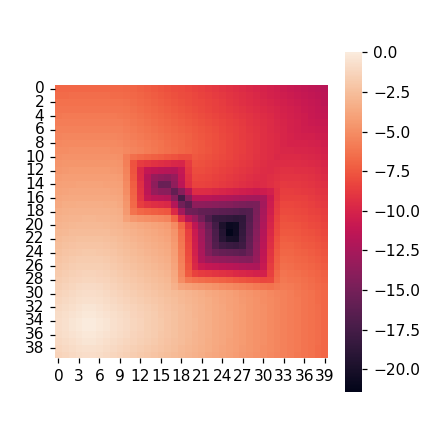

In [18]:
v = dp.value_function[:, :]
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
sns.heatmap(np.rot90(v), square=False)
plt.show()

<IPython.core.display.Javascript object>


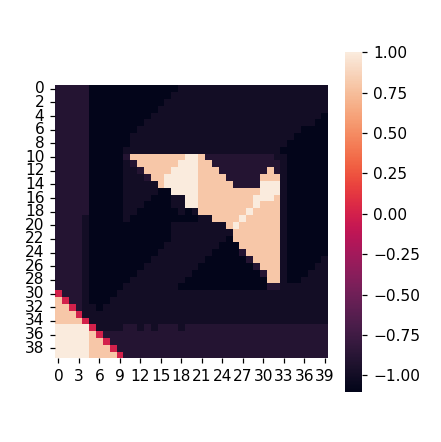

In [19]:
p = np.zeros(dp.index_nums) 
for i in dp.indexes:
    p[i] = sum(dp.policy[i]) 
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
sns.heatmap(np.rot90(p[:, :]), square=False)
plt.show()

## Demo

<IPython.core.display.Javascript object>


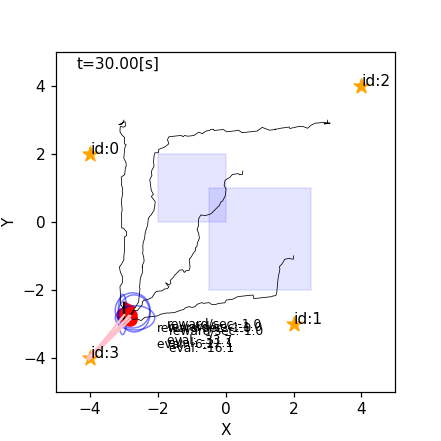

In [21]:
def trial():  ###puddle_world4_trial
    time_interval = 0.1
    world = PuddleWorld(30, time_interval, debug=False) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    for ln in [(-4,2), (2,-3), (4,4), (-4,-4)]: m.append_landmark(Landmark(*ln))
    world.append(m)   

    ##ゴールの追加##
    goal = Goal(-3,-3)  #goalを変数に
    world.append(goal)
    
    ##水たまりの追加##
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1)) 

#    ##ロボットを作る##

    init_poses = []
    for p in [[-3, 3], [0.5, 1.5], [3, 3], [2, -1]]:
        init_pose = np.array(p).T
        kf = KalmanFilter(m, init_pose)
        a = DpPolicyAgent(time_interval, kf, goal)
        r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
        world.append(r)
    world.draw()
    
trial()